Validation MAE: 15829.493565389555


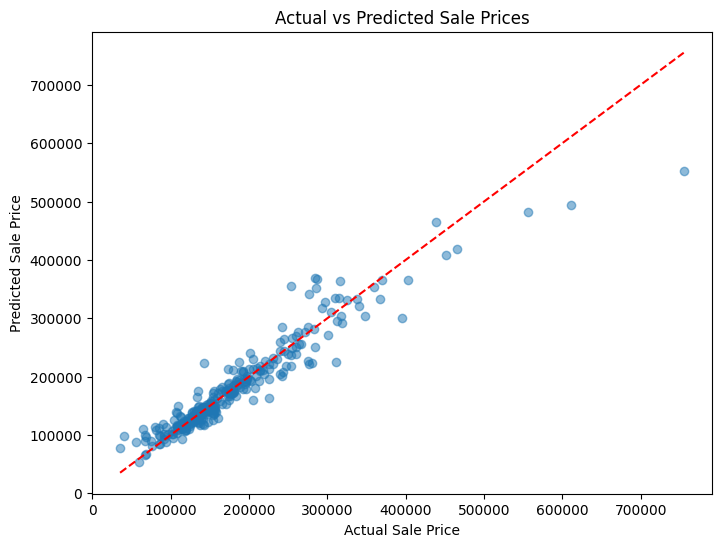

Submission file created successfully.
Mean error in predictions:  15829.493565389555


In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import shap

# Load data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Make a copy of the data for transformation
train_data_tunned = train_data.copy()
test_data_tunned = test_data.copy()

# Drop quality-related columns
#train_data_tunned.drop(['OverallQual', 'GarageCars'], axis=1, inplace=True)
#test_data_tunned.drop(['OverallQual', 'GarageCars'], axis=1, inplace=True)

# Handle categorical features with Label Encoding
label_encoders = {}
for col in train_data_tunned.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    all_data = pd.concat([train_data_tunned[col], test_data_tunned[col]], axis=0)
    le.fit(all_data.astype(str))  # Convert to string to avoid issues
    train_data_tunned[col] = le.transform(train_data_tunned[col].astype(str))
    test_data_tunned[col] = le.transform(test_data_tunned[col].astype(str))
    label_encoders[col] = le

# Feature Engineering
# Neighborhood median price feature
neighborhood_medians = train_data_tunned.groupby("Neighborhood")["SalePrice"].median()
train_data_tunned["_Neighborhood_MedianPrice"] = train_data_tunned["Neighborhood"].map(neighborhood_medians)
test_data_tunned["_Neighborhood_MedianPrice"] = test_data_tunned["Neighborhood"].map(neighborhood_medians)

# House age-related features
train_data_tunned["_HouseAge"] = train_data_tunned["YrSold"] - train_data_tunned["YearBuilt"]
train_data_tunned["_RemodelAge"] = train_data_tunned["YrSold"] - train_data_tunned["YearRemodAdd"]
train_data_tunned["_IsRemodeled"] = (train_data_tunned["YearBuilt"] != train_data_tunned["YearRemodAdd"]).astype(int)

test_data_tunned["_HouseAge"] = test_data_tunned["YrSold"] - test_data_tunned["YearBuilt"]
test_data_tunned["_RemodelAge"] = test_data_tunned["YrSold"] - test_data_tunned["YearRemodAdd"]
test_data_tunned["_IsRemodeled"] = (test_data_tunned["YearBuilt"] != test_data_tunned["YearRemodAdd"]).astype(int)

# Add total square feet
train_data_tunned["_TotalSF"] = train_data_tunned["1stFlrSF"] + train_data_tunned["2ndFlrSF"] + train_data_tunned["TotalBsmtSF"]
test_data_tunned["_TotalSF"] = test_data_tunned["1stFlrSF"] + test_data_tunned["2ndFlrSF"] + test_data_tunned["TotalBsmtSF"]

# Luxury feature indicators
train_data_tunned["_HasPool"] = (train_data_tunned["PoolArea"] > 0).astype(int)
train_data_tunned["_HasFireplace"] = (train_data_tunned["Fireplaces"] > 0).astype(int)
train_data_tunned["_HasSecondFloor"] = (train_data_tunned["2ndFlrSF"] > 0).astype(int)
train_data_tunned["_HasBasement"] = (train_data_tunned["TotalBsmtSF"] > 0).astype(int)

test_data_tunned["_HasPool"] = (test_data_tunned["PoolArea"] > 0).astype(int)
test_data_tunned["_HasFireplace"] = (test_data_tunned["Fireplaces"] > 0).astype(int)
test_data_tunned["_HasSecondFloor"] = (test_data_tunned["2ndFlrSF"] > 0).astype(int)
test_data_tunned["_HasBasement"] = (test_data_tunned["TotalBsmtSF"] > 0).astype(int)

# Define target and features
y = np.log(train_data_tunned['SalePrice'])  # Use log transformation
X = train_data_tunned.drop(columns=['SalePrice', 'Id'])  # Drop target and ID column
X_test = test_data_tunned.drop(columns=['Id'])  # Drop ID column

# Split data for validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Define XGBoost model
model = XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping_rounds=10,
                     objective='reg:squarederror', eval_metric='mae', random_state=42)

# Fit the model
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)

# Predict on validation set
val_predictions = model.predict(X_valid)

# Convert predictions back to original scale
y_valid_original = np.exp(y_valid)
val_predictions_original = np.exp(val_predictions)

# Calculate MAE
val_mae = mean_absolute_error(y_valid_original, val_predictions_original)
print(f"Validation MAE: {val_mae}")

# Scatter plot of true vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_valid_original, val_predictions_original, alpha=0.5)
plt.plot([y_valid_original.min(), y_valid_original.max()], [y_valid_original.min(), y_valid_original.max()], color='red', linestyle='--', label="Ideal Prediction")

plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Actual vs Predicted Sale Prices")
plt.show()

# Predict on test data
test_predictions = np.exp(model.predict(X_test))  # Convert back from log scale

# Prepare submission file
submission = pd.DataFrame({'Id': test_data['Id'], 'SalePrice': test_predictions})
submission.to_csv('submission.csv', index=False)

print("Submission file created successfully.")

#print mean error in predictions
print("Mean error in predictions: ", np.mean(np.abs(val_predictions_original - y_valid_original)))

### Feature importance with SHAP values

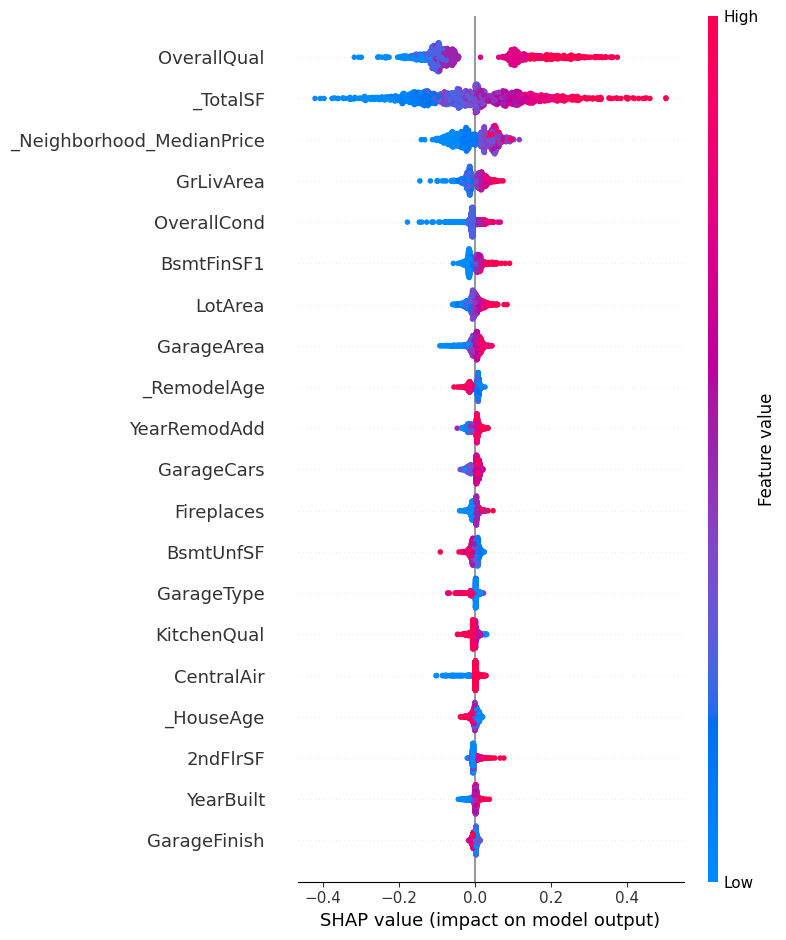

In [108]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

### SHAP values of high-error data points

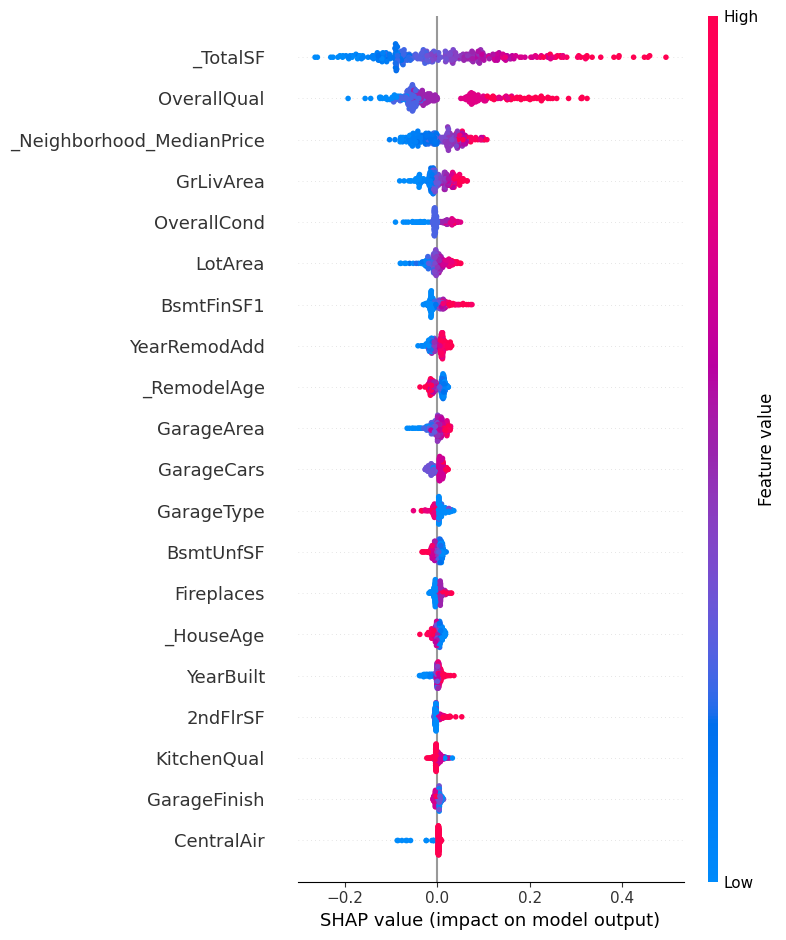

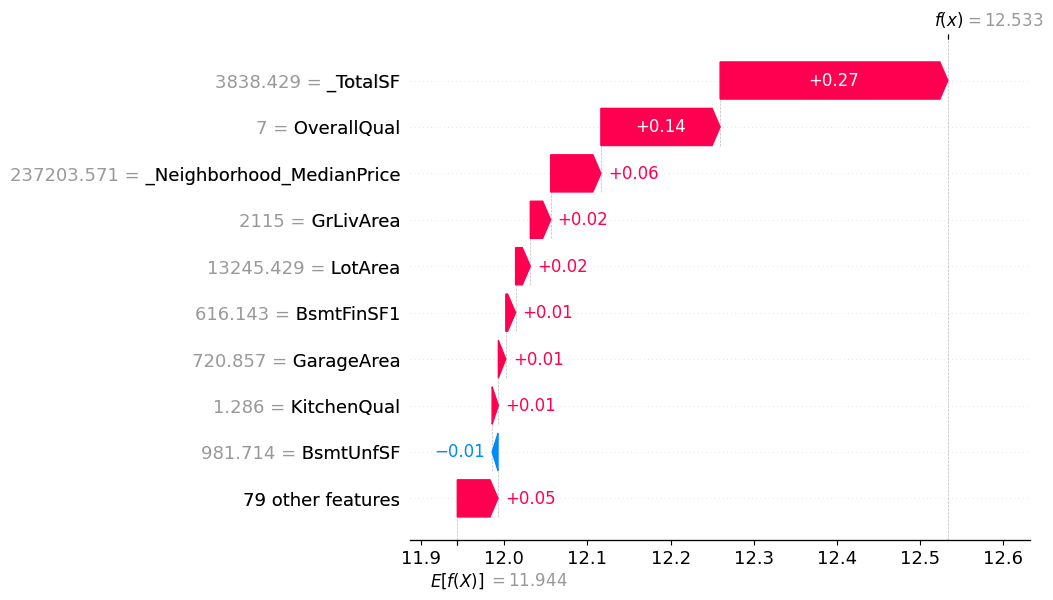

In [115]:
import shap
import numpy as np

# Create SHAP explainer for the model
explainer = shap.Explainer(model, X_valid)

# Compute SHAP values for the validation set
shap_values_valid = explainer(X_valid)

# Plot SHAP summary plot
shap.summary_plot(shap_values_valid, X_valid)

# Find all rows in the validation set where the prediction was overpriced by at least $50,000
high_error_rows = X_valid[(val_predictions_original - y_valid_original) > 50000]

# Get valid indices (ensure they exist in shap_values_valid)
valid_indices = X_valid.index.get_indexer(high_error_rows.index)
valid_indices = valid_indices[valid_indices >= 0]  # Remove any missing (-1) indices

# Get SHAP values for overpriced rows using the corrected indices
shap_values_high_error = shap_values_valid[valid_indices]

# Compute mean SHAP values for overpriced houses
mean_shap_values = np.mean(shap_values_high_error.values, axis=0)

# Convert mean SHAP values into a SHAP explanation object
mean_shap_explanation = shap.Explanation(
    values=mean_shap_values,
    base_values=np.mean(shap_values_high_error.base_values),
    data=np.mean(high_error_rows, axis=0),  # Use high_error_rows directly
    feature_names=X_valid.columns
)

# Generate the waterfall (cascade) plot
shap.plots.waterfall(mean_shap_explanation)
